In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [2]:
data = pd.read_csv('evaldata_shem_predflag.csv', index_col=0,header=0)

In [3]:
data.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2', 'j',
       'i', 'mod_microzooplankton', 'mod_mesozooplankton', 'k_upper',
       'k_lower', 'mod_total', 'mod_mesozooplanktonDI', 'L10Total',
       'L10TotalDI', 'L10mod_microzooplankton', 'L10mod_mesozooplankton',
       'L10mod_total', 'L10mod_mesozooplanktonDI', 'logt_invL10Total',
       'logt_invL10TotalDI', 'logt_invL10mod_mesozooplanktonDI',
       'SHEM_mesozooplankton', 'SHEM_mesozooplanktonDI',
       'L10SHEM_mesozooplankton', 'L10SHEM_mesozooplanktonDI',
       'logt_invL10SHEM_mesozooplanktonDI'],
      dtype='object')

In [4]:
print(data['Total'].min())
print(data['Total'].max())

0.1350045
1299.312525708672


In [5]:
print(data['Total'].mean())

41.51013501240886


In [6]:
print(data['mod_mesozooplankton'].min()*5.7*12)
print(data['mod_mesozooplankton'].max()*5.7*12)
print(data['mod_mesozooplankton'].mean()*5.7*12)

0.8132447226979369
157.36419216843095
36.87530215573653


In [7]:
print(data['SHEM_mesozooplankton'].min()*5.7*12)
print(data['SHEM_mesozooplankton'].max()*5.7*12)
print(data['SHEM_mesozooplankton'].mean()*5.7*12)

5.512123878790425
113.6299197405366
43.26070934189683


In [8]:
print(data['mod_total'].min()*5.7*12)
print(data['mod_total'].max()*5.7*12)
print(data['mod_total'].mean()*5.7*12)

0.8391957626855672
213.40867687256412
56.413933445692855


In [9]:
cm1=cmocean.cm.thermal
with nc.Dataset('//home/jvalenti/MOAD/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [10]:
data['broadregions']=np.nan

In [11]:
data.region_name

0       Whidbey Basin
1       Whidbey Basin
2       Central Basin
3       Central Basin
4       Central Basin
            ...      
2059    Whidbey Basin
2060    Whidbey Basin
2061    Central Basin
2062    Central Basin
2063    Central Basin
Name: region_name, Length: 2064, dtype: object

In [12]:
#data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')|(data.region_name=='Southern Strait of Georgia'),['broadregions']]='SoG'
data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia'),['broadregions']]='Main SoG'
data.loc[(data.region_name=='Southern Strait of Georgia'),['broadregions']]='Southern SoG'
data.loc[(data.region_name=='Nearshore-Central East')|(data.region_name=='Nearshore-North East')|(data.region_name=='Nearshore North West'),['broadregions']]='Nearshore'
data.loc[(data.region_name=='Baynes Sound'),['broadregions']]='Baynes'
data.loc[(data.region_name=='Tidal Mixed')|(data.region_name=='Gulf Islands')|(data.region_name=='San Juan Islands')|(data.region_name=='San Juan'),['broadregions']]='Mixed'
data.loc[(data.region_name=='Juan de Fuca'),['broadregions']]='JdeF'

data.loc[(data.region_name=='Whidbey Basin')|(data.region_name=='Bellingham Bay')|(data.region_name=='Admiralty Inlet'),['broadregions']]='North Sound'
data.loc[(data.region_name=='Central Basin'),['broadregions']]='Central Sound'
data.loc[(data.region_name=='South Sound')|(data.region_name=='Hood Canal'),['broadregions']]='South Sound'
#data.loc[(data.region_name=='Hood Canal'),['broadregions']]='Hood Canal'

/tmp/ipykernel_3257766/1293757410.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Main SoG' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia'),['broadregions']]='Main SoG'


In [13]:
#data.loc[data['broadregions']=='SoG']

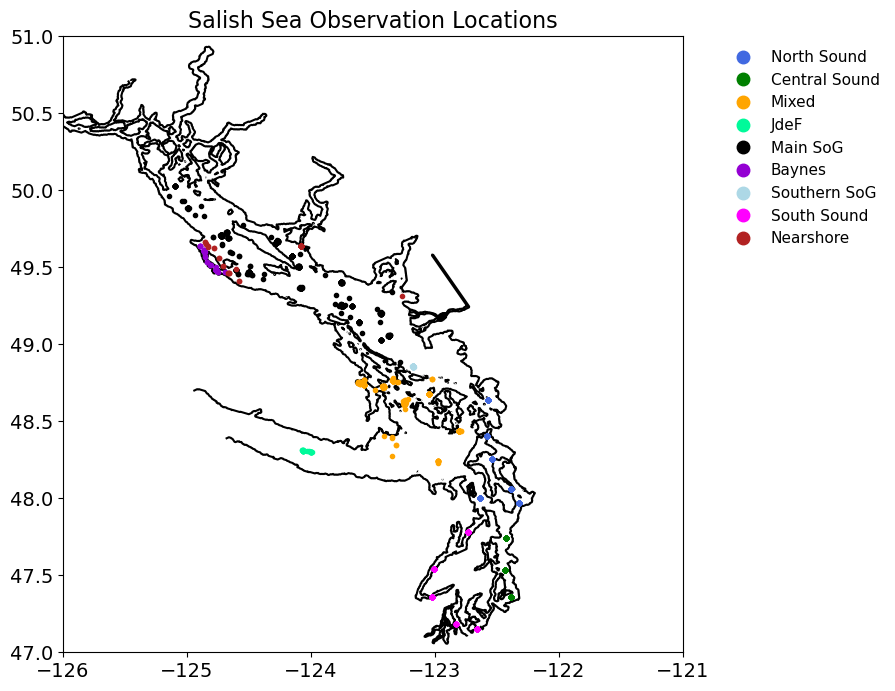

In [14]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/home/jvalenti/MOAD/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('royalblue',
'green',
'orange',
'mediumspringgreen',
'black',
'darkviolet',
 'lightblue',
'fuchsia',
'firebrick','lime','darkgoldenrod','darkorange','deepskyblue','teal','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.broadregions.unique()):
    datreg[iregion] = data.loc[data.broadregions==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Salish Sea Observation Locations');
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [15]:
def byRegion(ax,obsvar,modvar,lims):
    SS=[]
    for ind, iregion in enumerate(data.broadregions.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SS.append(SS0)
    l=ax.legend(handles=[ip[0][0] for ip in SS])
    ax.set_xlabel('Log10 Observations (g C m$^{-2}$) +0.001 ')
    ax.set_ylabel('Log10 Model (g C m$^{-2}$) +0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [16]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [17]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

In [18]:
data.region_name.unique()

array(['Whidbey Basin', 'Central Basin', 'Tidal Mixed', 'Juan de Fuca',
       'Northern Strait of Georgia', 'Central Strait of Georgia',
       'Baynes Sound', 'Gulf Islands', 'Southern Strait of Georgia',
       'Admiralty Inlet', 'Hood Canal', 'Nearshore-North East',
       'South Sound', 'Bellingham Bay', 'San Juan',
       'Nearshore North West', 'San Juan Islands',
       'Nearshore-Central East'], dtype=object)

In [19]:
data['Month']

0        1
1        1
2        1
3        1
4        1
        ..
2059    12
2060    12
2061    12
2062    12
2063    12
Name: Month, Length: 2064, dtype: int64

In [20]:
#data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')|(data.region_name=='Southern Strait of Georgia'),['broadregions']]='SoG'
MainSoG=data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')]
SouthernSoG=data.loc[(data.region_name=='Southern Strait of Georgia')]
Nearshore=data.loc[(data.region_name=='Nearshore-Central East')|(data.region_name=='Nearshore-North East')|(data.region_name=='Nearshore North West')]
Baynes=data.loc[(data.region_name=='Baynes Sound')]
Mixed=data.loc[(data.region_name=='Tidal Mixed')|(data.region_name=='Gulf Islands')|(data.region_name=='San Juan Islands')|(data.region_name=='San Juan')]
JdeF=data.loc[(data.region_name=='Juan de Fuca')]

NorthSound=data.loc[(data.region_name=='Whidbey Basin')|(data.region_name=='Bellingham Bay')|(data.region_name=='Admiralty Inlet')]
CentralSound=data.loc[(data.region_name=='Central Basin')]
SouthSound=data.loc[(data.region_name=='South Sound')|(data.region_name=='Hood Canal')]
#data.loc[(data.region_name=='Hood Canal'),['broadregions']]='Hood Canal'

In [21]:
MainSoG.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2', 'j',
       'i', 'mod_microzooplankton', 'mod_mesozooplankton', 'k_upper',
       'k_lower', 'mod_total', 'mod_mesozooplanktonDI', 'L10Total',
       'L10TotalDI', 'L10mod_microzooplankton', 'L10mod_mesozooplankton',
       'L10mod_total', 'L10mod_mesozooplanktonDI', 'logt_invL10Total',
       'logt_invL10TotalDI', 'logt_invL10mod_mesozooplanktonDI',
       'SHEM_mesozooplankton', 'SHEM_mesozooplanktonDI',
       'L10SHEM_mesozooplankton', 'L10SHEM_mesozooplanktonDI',
       'logt_invL10SHEM_mesozooplanktonDI', 'broadregions'],
      dtype='object')

In [22]:
monthlymeanMainSoG=MainSoG.groupby(['Month'])[MainSoG.select_dtypes(include="number").columns].mean()
monthlymeanSouthernSoG=SouthernSoG.groupby(['Month'])[SouthernSoG.select_dtypes(include="number").columns].mean()
monthlymeanNearshore=Nearshore.groupby(['Month'])[Nearshore.select_dtypes(include="number").columns].mean()
monthlymeanBaynes=Baynes.groupby(['Month'])[Baynes.select_dtypes(include="number").columns].mean()
monthlymeanMixed=Mixed.groupby(['Month'])[Mixed.select_dtypes(include="number").columns].mean()
monthlymeanJdeF=JdeF.groupby(['Month'])[JdeF.select_dtypes(include="number").columns].mean()
monthlymeanSouthSound=SouthSound.groupby(['Month'])[SouthSound.select_dtypes(include="number").columns].mean()
monthlymeanNorthSound=NorthSound.groupby(['Month'])[NorthSound.select_dtypes(include="number").columns].mean()
monthlymeanCentralSound=CentralSound.groupby(['Month'])[CentralSound.select_dtypes(include="number").columns].mean()

monthlymean=data.groupby(['Month'])[data.select_dtypes(include="number").columns].mean()

In [23]:
monthlysemMainSoG=MainSoG.groupby(['Month'])[MainSoG.select_dtypes(include="number").columns].sem()
monthlysemSouthernSoG=SouthernSoG.groupby(['Month'])[SouthernSoG.select_dtypes(include="number").columns].sem()
monthlysemNearshore=Nearshore.groupby(['Month'])[Nearshore.select_dtypes(include="number").columns].sem()
monthlysemBaynes=Baynes.groupby(['Month'])[Baynes.select_dtypes(include="number").columns].sem()
monthlysemMixed=Mixed.groupby(['Month'])[Mixed.select_dtypes(include="number").columns].sem()
monthlysemJdeF=JdeF.groupby(['Month'])[JdeF.select_dtypes(include="number").columns].sem()
monthlysemSouthSound=SouthSound.groupby(['Month'])[SouthSound.select_dtypes(include="number").columns].sem()
monthlysemNorthSound=NorthSound.groupby(['Month'])[NorthSound.select_dtypes(include="number").columns].sem()
monthlysemCentralSound=CentralSound.groupby(['Month'])[CentralSound.select_dtypes(include="number").columns].sem()

monthlysem=data.groupby(['Month'])[data.select_dtypes(include="number").columns].sem()

In [24]:
print(monthlymean['Total'].mean())
print(monthlymean['mod_total'].mean()*5.7*12)

35.41903429374266
50.03850437051078


In [25]:
print(monthlymean['Total'].min())
print(monthlymean['mod_mesozooplankton'].min()*5.7*12)
print(monthlymean['SHEM_mesozooplankton'].min()*5.7*12)

13.366664537920263
17.03401975899197
18.422171576119524


In [26]:
print(monthlymean['Total'].max())
print(monthlymean['mod_mesozooplankton'].max()*5.7*12)
print(monthlymean['SHEM_mesozooplankton'].max()*5.7*12)

57.805534370671346
45.83657758060018
56.808686331498


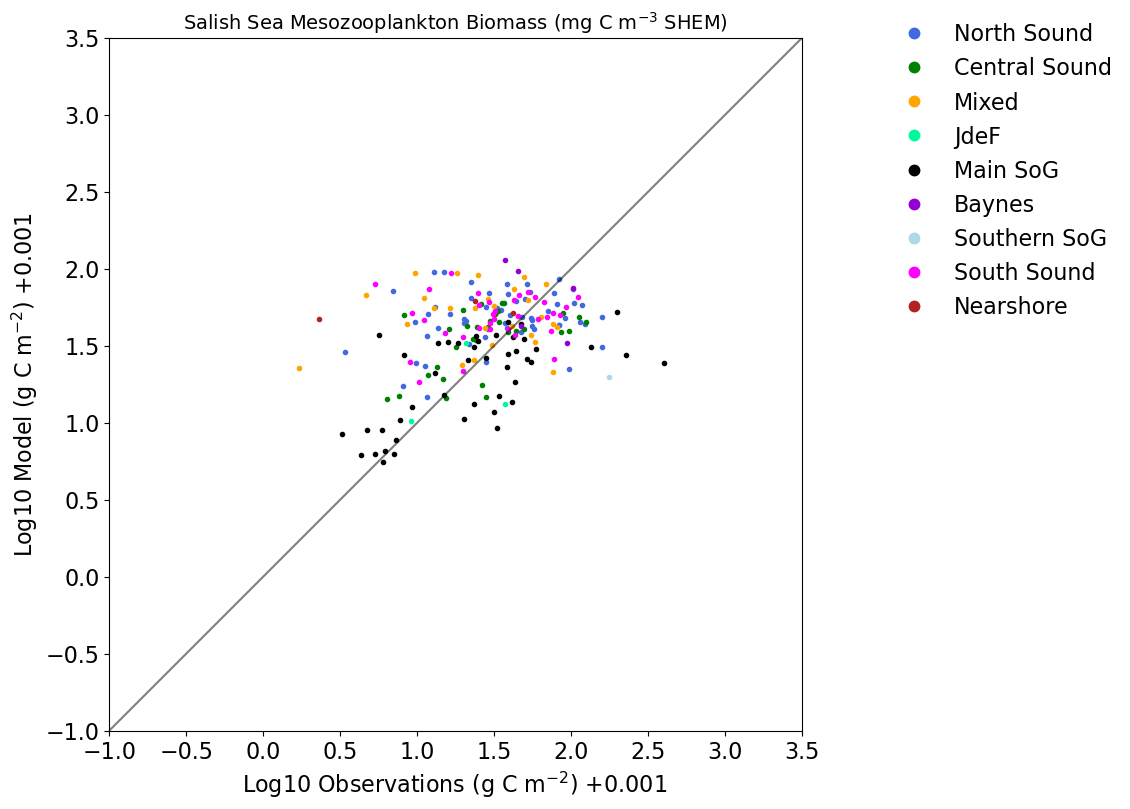

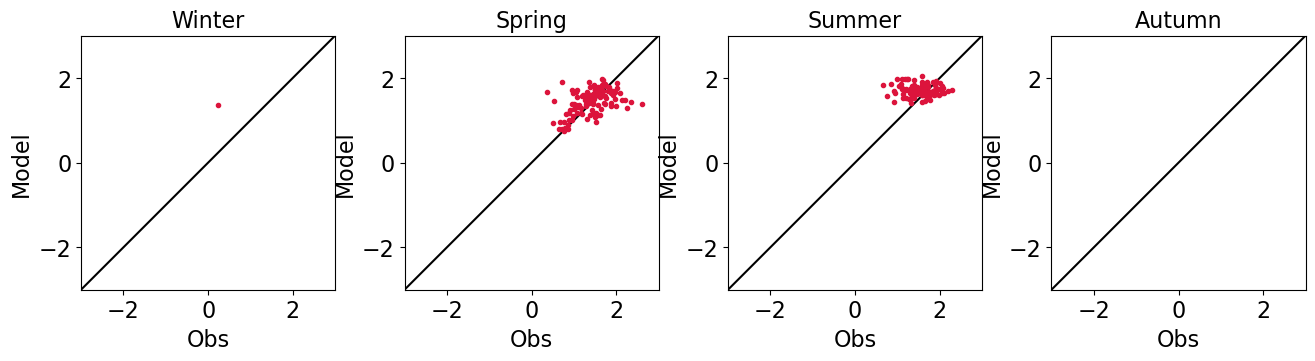

In [27]:
fig, ax = plt.subplots(1,1,figsize = (16,9))     
PS,l=byRegion(ax,'L10Total','L10SHEM_mesozooplankton',(-1,3.5))
ax.set_title('Salish Sea Mesozooplankton Biomass (mg C m$^{-3}$ SHEM)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaMesoZoopEval_byregion.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Total','L10SHEM_mesozooplankton',(-3,3))

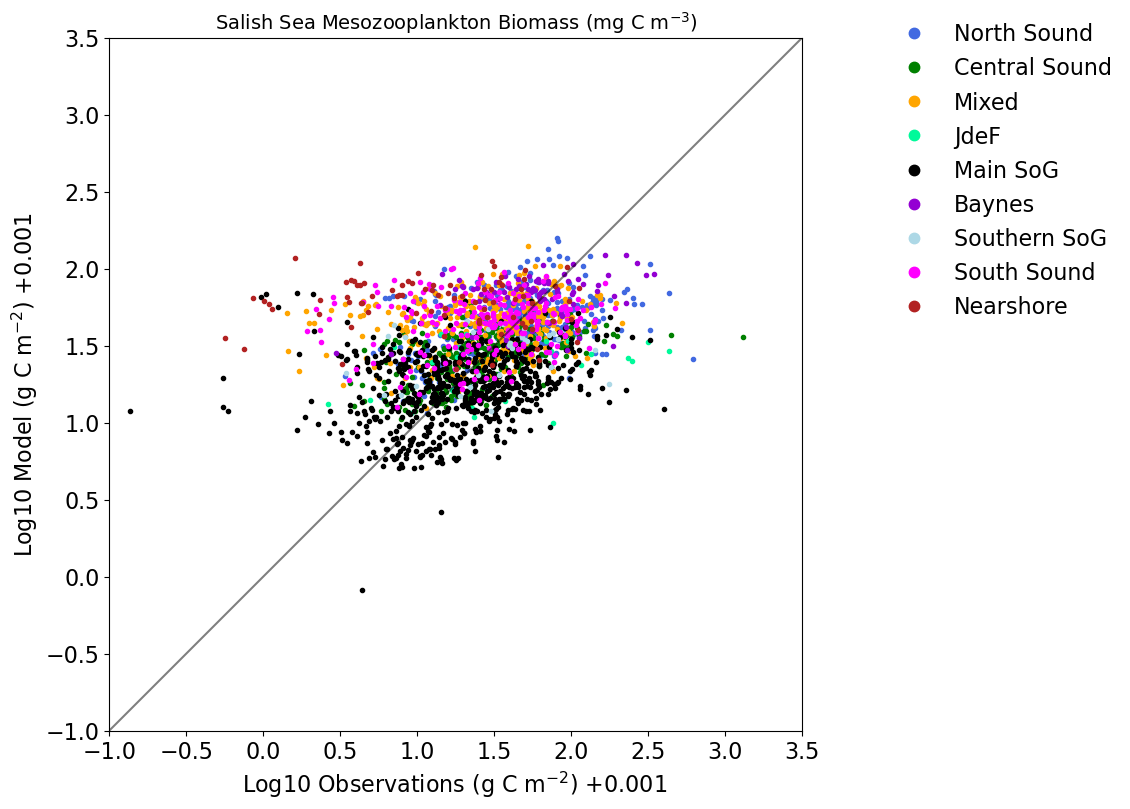

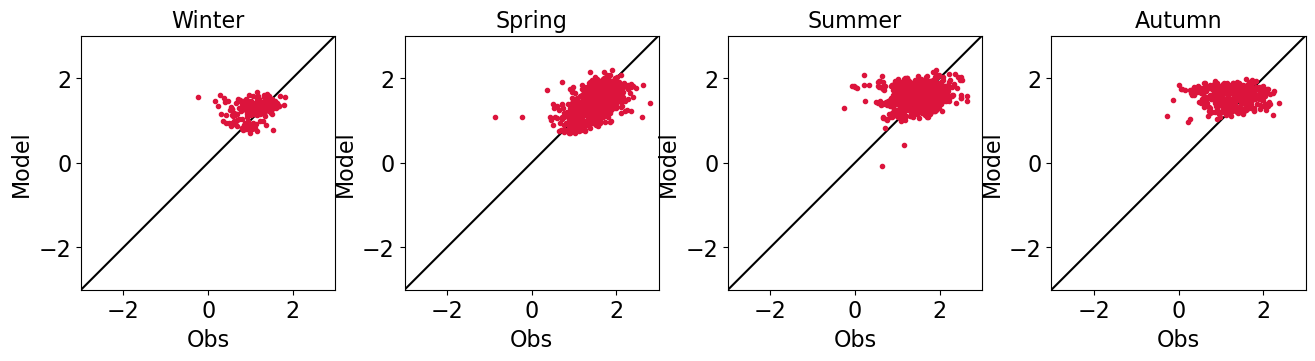

In [28]:
fig, ax = plt.subplots(1,1,figsize = (16,9))     
PS,l=byRegion(ax,'L10Total','L10mod_mesozooplankton',(-1,3.5))
ax.set_title('Salish Sea Mesozooplankton Biomass (mg C m$^{-3}$)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaMesoZoopEval_byregion.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Total','L10mod_mesozooplankton',(-3,3))

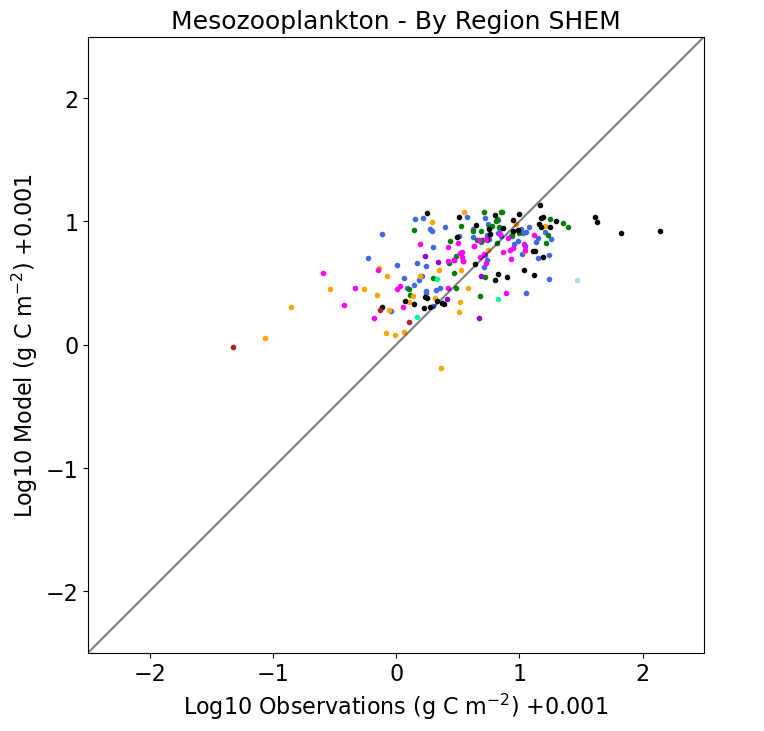

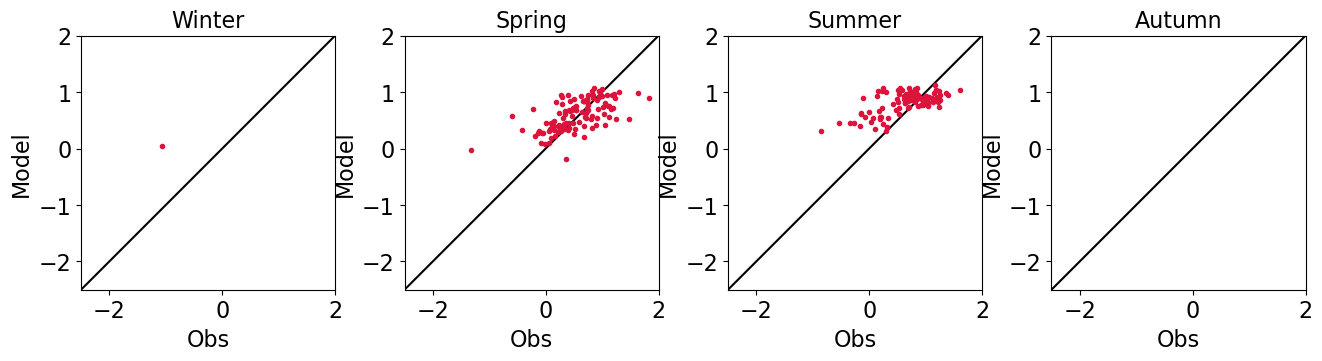

In [29]:
fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,'L10TotalDI','L10SHEM_mesozooplanktonDI',(-2.5,2.5))
ax.set_title('Mesozooplankton - By Region SHEM',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMesoZoopEval_byregion_noLegend.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10TotalDI','L10SHEM_mesozooplanktonDI',(-2.5,2))

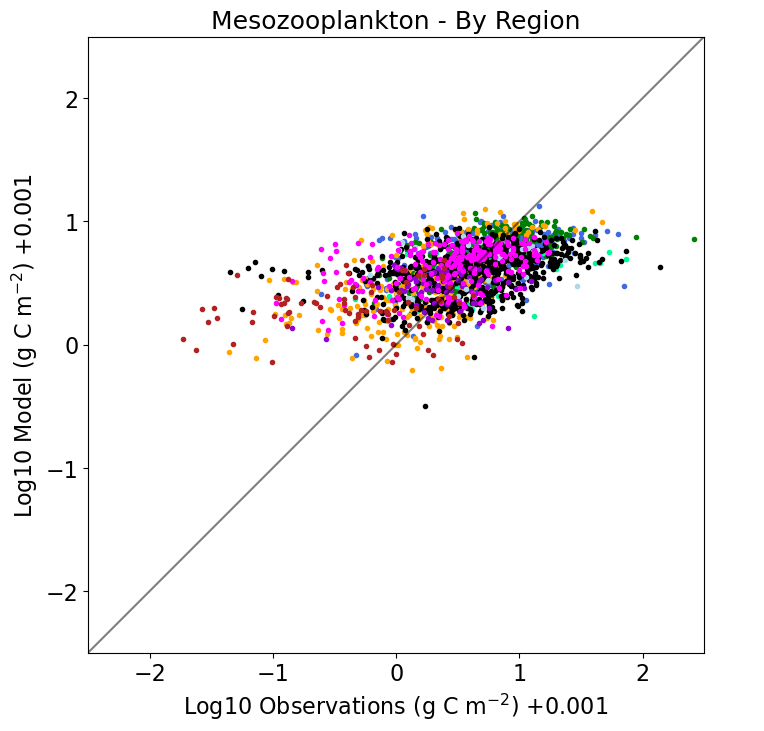

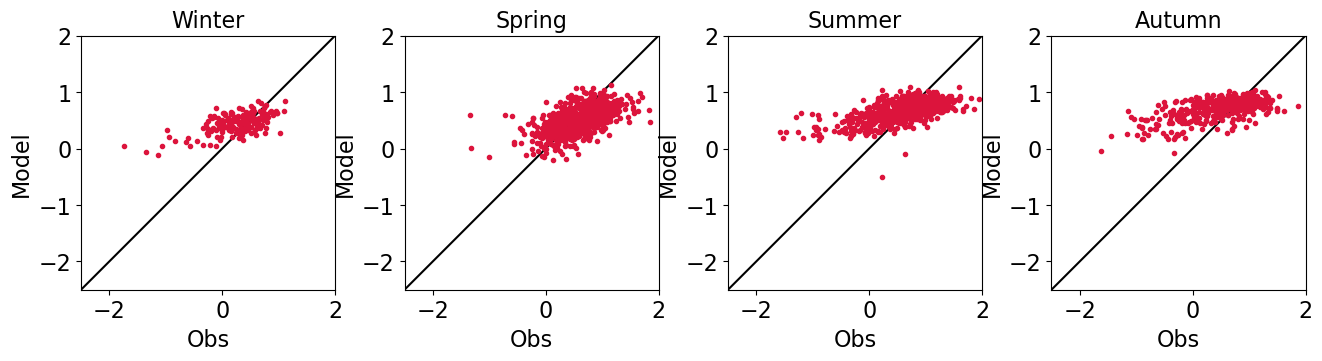

In [30]:
fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,'L10TotalDI','L10mod_mesozooplanktonDI',(-2.5,2.5))
ax.set_title('Mesozooplankton - By Region',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMesoZoopEval_byregion_noLegend.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10TotalDI','L10mod_mesozooplanktonDI',(-2.5,2))

In [31]:
x_values=data['L10TotalDI']
y_values=data['L10SHEM_mesozooplanktonDI']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10SHEM_mesozooplanktonDI))
x2_values=data.loc[iii,['L10TotalDI']].values[:,0]
y2_values=data.loc[iii,['L10SHEM_mesozooplanktonDI']].values[:,0]

correlation_matrix = np.corrcoef(x2_values, y2_values)
correlation_xy = correlation_matrix[0,1]
r2shem = correlation_xy**2

x_values=data['L10TotalDI']
y_values=data['L10mod_mesozooplanktonDI']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10mod_mesozooplanktonDI))
x2_values=data.loc[iii,['L10TotalDI']].values[:,0]
y2_values=data.loc[iii,['L10mod_mesozooplanktonDI']].values[:,0]

correlation_matrix = np.corrcoef(x2_values, y2_values)
correlation_xy = correlation_matrix[0,1]
r2 = correlation_xy**2

Text(1.5, -2.25, 'R$^{2}$ =0.37')

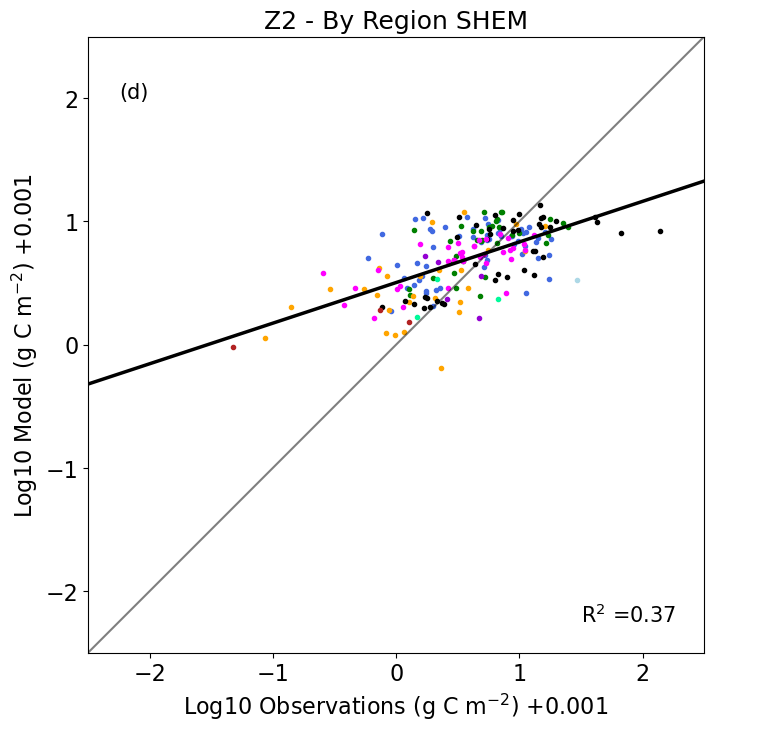

In [32]:
x=['L10TotalDI']
y=['L10SHEM_mesozooplanktonDI']
#datatemp=datreg['South Sound']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10SHEM_mesozooplanktonDI))
x2shem=data.loc[iii,['L10TotalDI']].values[:,0]
y2shem=data.loc[iii,['L10SHEM_mesozooplanktonDI']].values[:,0]

fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,'L10TotalDI','L10SHEM_mesozooplanktonDI',(-2.5,2.5))
ax.set_title('Z2 - By Region SHEM',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2shem, y2shem, 1)

xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);
ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ ='+ str(round(r2shem,2)), fontsize=15,  color='k')

#plt.savefig('SalishSeaDIMesoZoopEval_byregion_noLegend.png', bbox_inches='tight',dpi=1000,transparent=False)


Text(1.5, -2.25, 'R$^{2}$ =0.28')

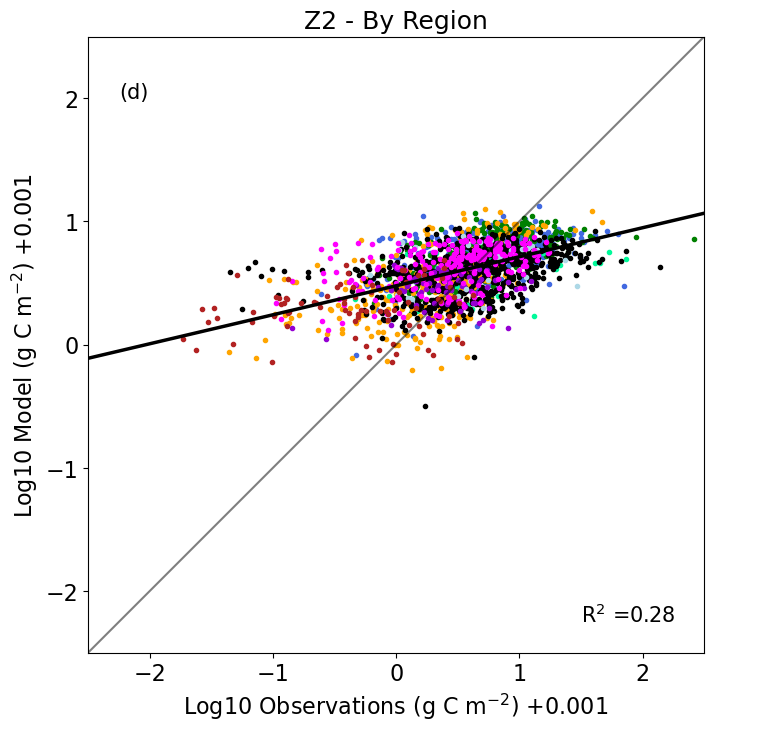

In [33]:
x=['L10TotalDI']
y=['L10mod_mesozooplanktonDI']
#datatemp=datreg['South Sound']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10mod_mesozooplanktonDI))
x2=data.loc[iii,['L10TotalDI']].values[:,0]
y2=data.loc[iii,['L10mod_mesozooplanktonDI']].values[:,0]

fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,'L10TotalDI','L10mod_mesozooplanktonDI',(-2.5,2.5))
ax.set_title('Z2 - By Region',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2, y2, 1)

xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);
ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ ='+ str(round(r2,2)), fontsize=15,  color='k')

#plt.savefig('SalishSeaDIMesoZoopEval_byregion_noLegend.png', bbox_inches='tight',dpi=1000,transparent=False)


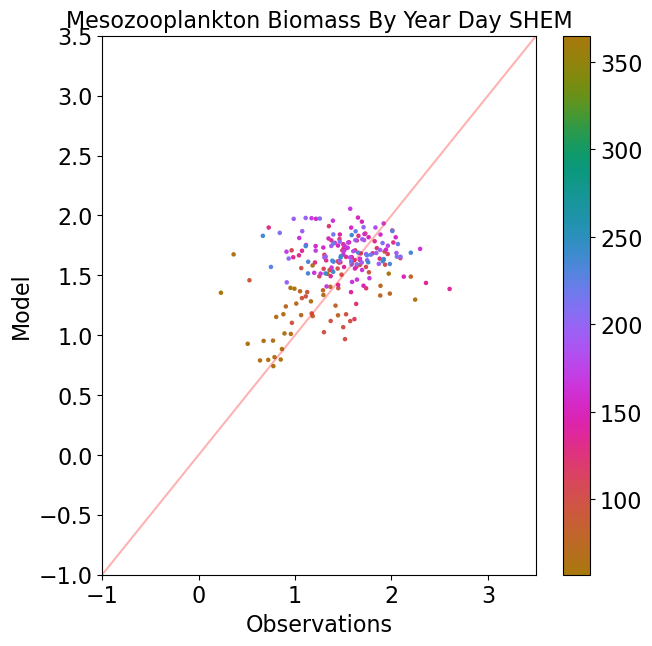

In [34]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
m=ax.scatter((data['L10Total']),(data['L10SHEM_mesozooplankton']),
          c=data['YD'],s=5,cmap=cmocean.cm.phase,vmax=365)

ax.set_title('Mesozooplankton Biomass By Year Day SHEM')
ax.set_xlabel('Observations')
ax.set_ylabel('Model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,3.5)
ax.set_ylim(-1,3.5)
fig.colorbar(m)
#fig.savefig('SalishSeaMesozoopModelvsObsbyDOY.png',bbox_inches='tight')

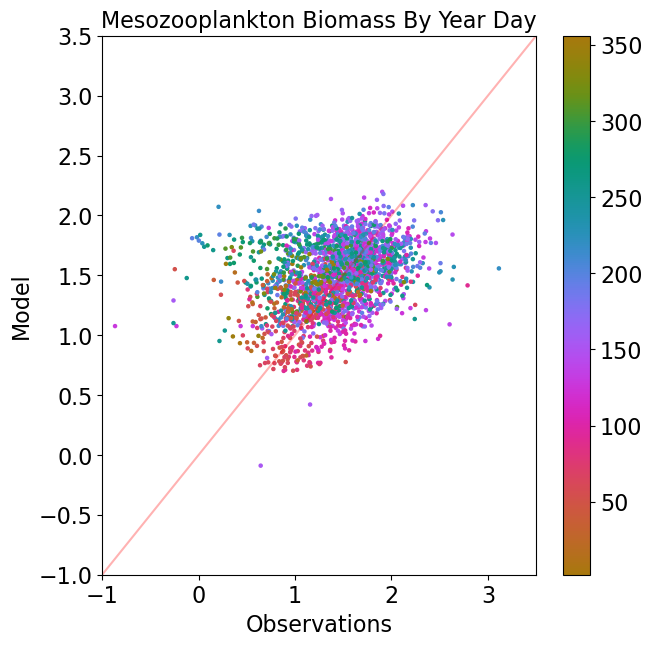

In [35]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
m=ax.scatter((data['L10Total']),(data['L10mod_mesozooplankton']),
          c=data['YD'],s=5,cmap=cmocean.cm.phase)

ax.set_title('Mesozooplankton Biomass By Year Day')
ax.set_xlabel('Observations')
ax.set_ylabel('Model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,3.5)
ax.set_ylim(-1,3.5);
fig.colorbar(m)
#fig.savefig('SalishSeaMesozoopModelvsObsbyDOY.png',bbox_inches='tight')

Text(1.5, -2.25, 'R$^{2}$ =0.37')

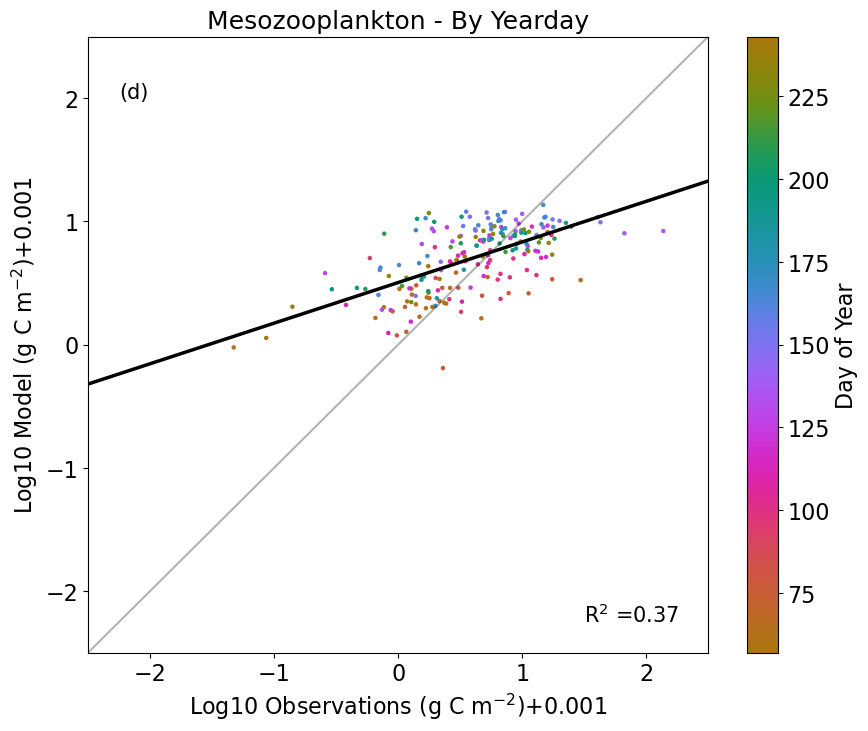

In [36]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
m=ax.scatter((data['L10TotalDI']),(data['L10SHEM_mesozooplanktonDI']),
          c=data['YD'],s=5,cmap=cmocean.cm.phase)

ax.set_title('Mesozooplankton - By Yearday',fontsize=18)
ax.set_xlabel('Log10 Observations (g C m$^{-2}$)+0.001')
ax.set_ylabel('Log10 Model (g C m$^{-2}$)+0.001')
ax.plot((-6,5),(-6,5),'k-',alpha=.3)
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5);
fig.colorbar(m,label='Day of Year')

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2shem, y2shem, 1)

#xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);

ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ ='+ str(round(r2shem,2)), fontsize=15,  color='k')

#plt.savefig('SalishSeaDIMesozoopModelvsObsbyDOY.png', bbox_inches='tight',dpi=1000,transparent=False)


Text(1.5, -2.25, 'R$^{2}$ =0.28')

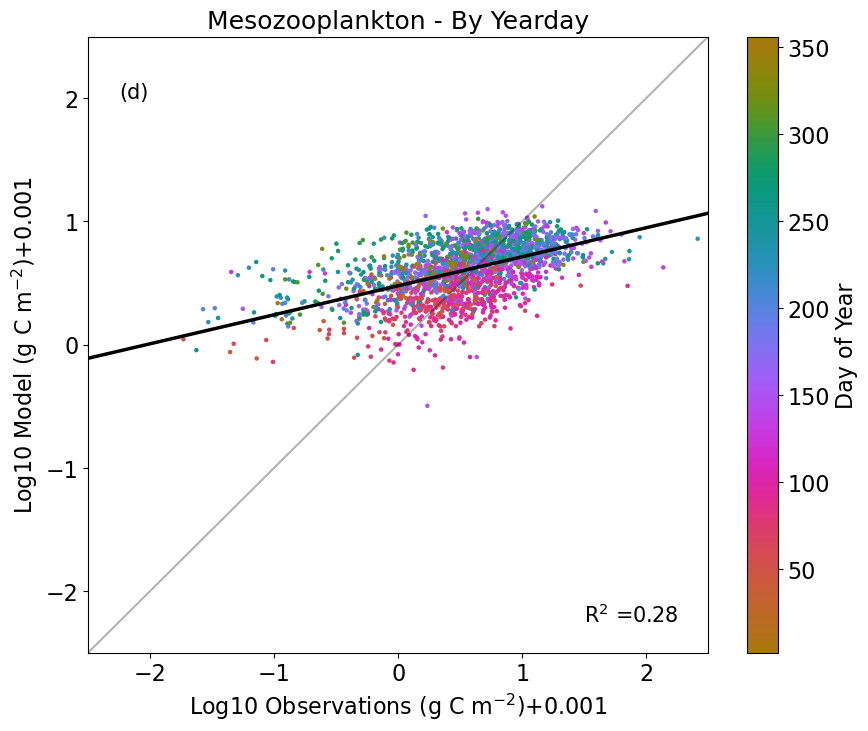

In [37]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
m=ax.scatter((data['L10TotalDI']),(data['L10mod_mesozooplanktonDI']),
          c=data['YD'],s=5,cmap=cmocean.cm.phase)

ax.set_title('Mesozooplankton - By Yearday',fontsize=18)
ax.set_xlabel('Log10 Observations (g C m$^{-2}$)+0.001')
ax.set_ylabel('Log10 Model (g C m$^{-2}$)+0.001')
ax.plot((-6,5),(-6,5),'k-',alpha=.3)
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5);
fig.colorbar(m,label='Day of Year')

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2, y2, 1)

#xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);

ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ ='+ str(round(r2,2)), fontsize=15,  color='k')

#plt.savefig('SalishSeaDIMesozoopModelvsObsbyDOY.png', bbox_inches='tight',dpi=1000,transparent=False)


In [38]:
from matplotlib.colors import LogNorm

Text(-2.25, 2, '(d)')

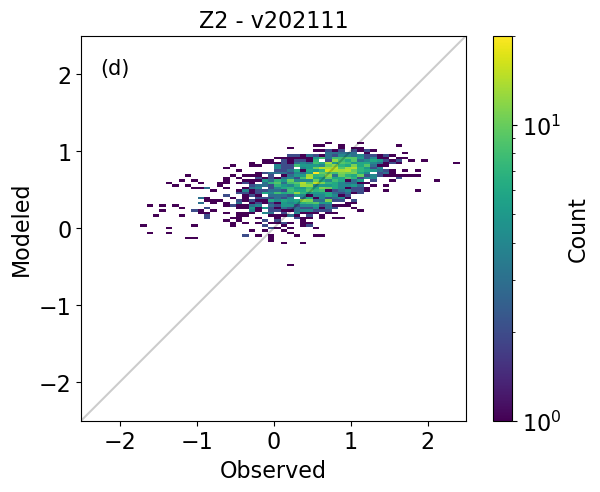

In [39]:
data=data
fig,ax=plt.subplots(1,1,figsize=(7,5))
ii=(~np.isnan(data['L10TotalDI']))&(~np.isnan(data['L10mod_mesozooplanktonDI']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['L10TotalDI']].values.flatten()+.001),
                                      (data.loc[ii,['L10mod_mesozooplanktonDI']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2.5,2.5),(-2.5,2.5),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)
ax.set_aspect(1)
ax.set_ylabel('Modeled',fontsize=16)
ax.set_xlabel('Observed',fontsize=16)
ax.set_title('Z2 - v202111',fontsize=16)
ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')



Text(-2.25, 2, '(d)')

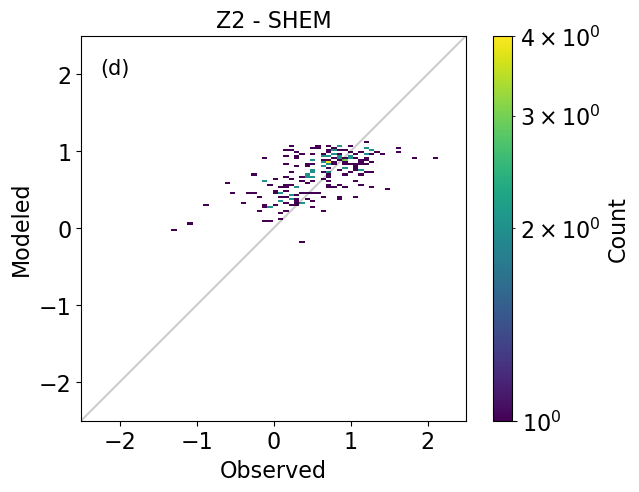

In [40]:
data=data
fig,ax=plt.subplots(1,1,figsize=(7,5))
ii=(~np.isnan(data['L10TotalDI']))&(~np.isnan(data['L10SHEM_mesozooplanktonDI']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['L10TotalDI']].values.flatten()+.001),
                                      (data.loc[ii,['L10SHEM_mesozooplanktonDI']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2.5,2.5),(-2.5,2.5),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)
ax.set_aspect(1)
ax.set_ylabel('Modeled',fontsize=16)
ax.set_xlabel('Observed',fontsize=16)
ax.set_title('Z2 - SHEM',fontsize=16)
ax.text(-2.25, 2, '(d)', fontsize=15,  color='k')



In [41]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

/tmp/ipykernel_3257766/2861418980.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Total'])),
/tmp/ipykernel_3257766/2861418980.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_mesozooplankton'])),
/tmp/ipykernel_3257766/2861418980.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10SHEM_mesozooplankton'])),


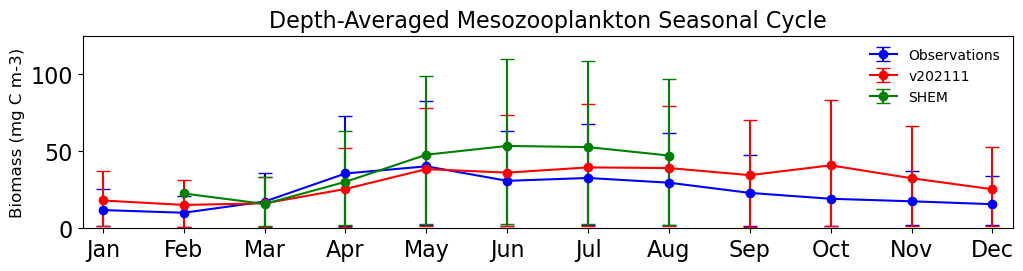

In [42]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named


#ax.plot(logt_inv(monthlymean['L10Total']),'--',color='k',label='Observations')
#ax.plot(logt_inv(monthlymean['L10mod_mesozooplankton']),'--',color='blue',label='Model')
ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Total'])),
               yerr=(np.array([logt_inv(monthlymean['L10Total']-monthlysem['L10Total']),
                 logt_inv(monthlymean['L10Total']+monthlysem['L10Total'])])),
              fmt='r-o',capsize=5,color='blue',label='Observations')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_mesozooplankton'])),
               yerr=(np.array([logt_inv(monthlymean['L10mod_mesozooplankton']-monthlysem['L10mod_mesozooplankton']),
                 logt_inv(monthlymean['L10mod_mesozooplankton']+monthlysem['L10mod_mesozooplankton'])])),
              fmt='k-o',capsize=5,color='red',label='v202111')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10SHEM_mesozooplankton'])),
               yerr=(np.array([logt_inv(monthlymean['L10SHEM_mesozooplankton']-monthlysem['L10SHEM_mesozooplankton']),
                 logt_inv(monthlymean['L10SHEM_mesozooplankton']+monthlysem['L10SHEM_mesozooplankton'])])),
              fmt='k-o',capsize=5,color='green',label='SHEM')

ax.set_ylim(0,125)
ax.set_xlim(0.75,12.25)
ax.set_title('Depth-Averaged Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
fig.savefig('SoGMesozoopSeasonalCycle.png',bbox_inches='tight')

/tmp/ipykernel_3257766/1907439473.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10TotalDI'])),
/tmp/ipykernel_3257766/1907439473.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_mesozooplanktonDI'])),
/tmp/ipykernel_3257766/1907439473.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10SHEM_mesozooplanktonDI'])),


Text(1, 12, '(b)')

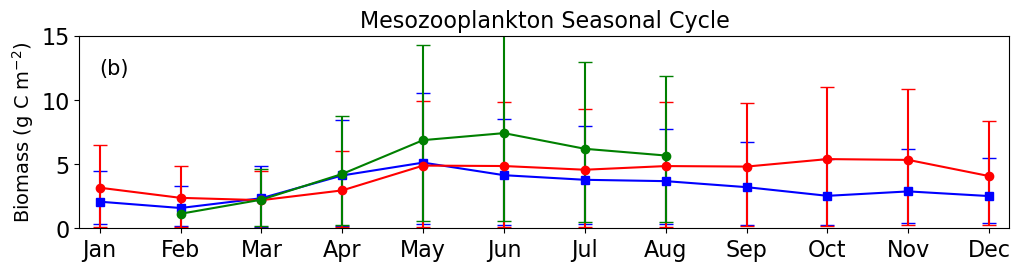

In [43]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named


#ax.plot(logt_inv(monthlymean['L10Total']),'--',color='k',label='Observations')
#ax.plot(logt_inv(monthlymean['L10mod_mesozooplanktonDI']),'--',color='blue',label='Model')
ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10TotalDI'])),
               yerr=(np.array([logt_inv(monthlymean['L10TotalDI']-monthlysem['L10TotalDI']),
                 logt_inv(monthlymean['L10TotalDI']+monthlysem['L10TotalDI'])])),
              fmt='r',marker='s',capsize=5,color='blue',label='Observations')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_mesozooplanktonDI'])),
               yerr=(np.array([logt_inv(monthlymean['L10mod_mesozooplanktonDI']-monthlysem['L10mod_mesozooplanktonDI']),
                 logt_inv(monthlymean['L10mod_mesozooplanktonDI']+monthlysem['L10mod_mesozooplanktonDI'])])),
              fmt='k-o',capsize=5,color='red',label='v202111')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10SHEM_mesozooplanktonDI'])),
               yerr=(np.array([logt_inv(monthlymean['L10SHEM_mesozooplanktonDI']-monthlysem['L10SHEM_mesozooplanktonDI']),
                 logt_inv(monthlymean['L10SHEM_mesozooplanktonDI']+monthlysem['L10SHEM_mesozooplanktonDI'])])),
              fmt='k-o',capsize=5,color='green',label='SHEM')

ax.set_ylim(0,15)
ax.set_xlim(0.75,12.25)
ax.set_title('Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (g C m$^{-2}$)',fontsize=14)
ax.legend((),fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
ax.text(1, 12, '(b)', fontsize=15,  color='k')

#plt.savefig('SalishSeaMesozoopSeasonalCycle.png', bbox_inches='tight',dpi=1000,transparent=False)


In [44]:
logt_inv(monthlymean['L10SHEM_mesozooplanktonDI'])

Month
1          NaN
2     1.129794
3     2.229262
4     4.234183
5     6.868590
6     7.414365
7     6.193169
8     5.669523
9          NaN
10         NaN
11         NaN
12         NaN
Name: L10SHEM_mesozooplanktonDI, dtype: float64

In [45]:
logt_inv(monthlymean['L10mod_mesozooplanktonDI'])

Month
1     3.161599
2     2.371162
3     2.189612
4     2.952409
5     4.884247
6     4.850594
7     4.561641
8     4.847644
9     4.807700
10    5.390862
11    5.326811
12    4.066260
Name: L10mod_mesozooplanktonDI, dtype: float64

In [46]:
logt_inv(monthlymean['L10TotalDI'])

Month
1     2.072309
2     1.579472
3     2.343550
4     4.116709
5     5.117297
6     4.136211
7     3.777678
8     3.671987
9     3.203481
10    2.528688
11    2.873129
12    2.509341
Name: L10TotalDI, dtype: float64

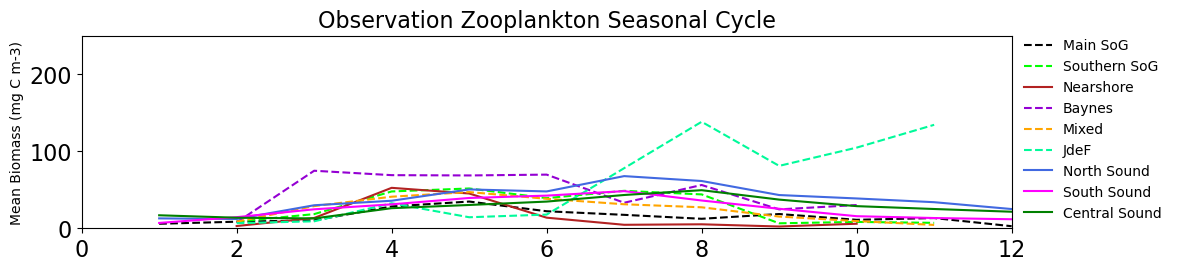

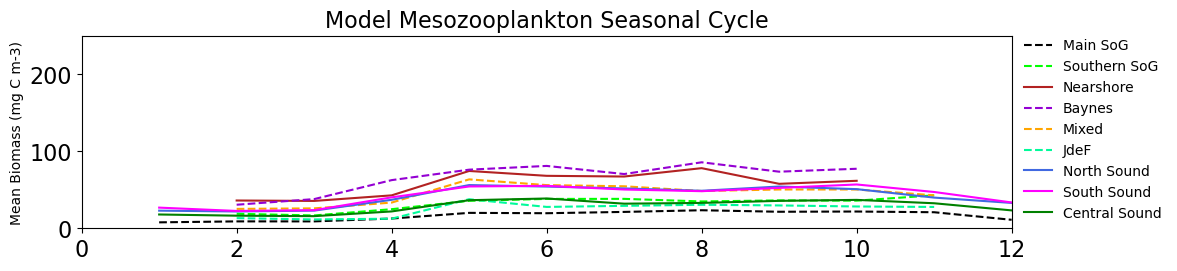

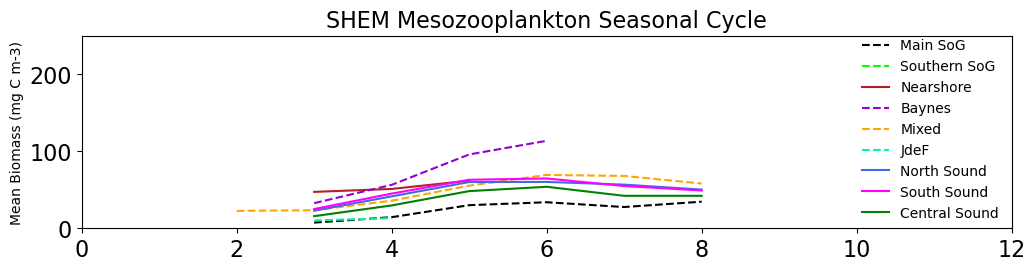

In [47]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10Total']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10Total']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10Total']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10Total']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10Total']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10Total']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10Total']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10Total']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10Total']),'-',color='green',label='Central Sound')
ax.set_ylim(0,250)
ax.set_xlim(0,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10mod_mesozooplankton']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10mod_mesozooplankton']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10mod_mesozooplankton']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10mod_mesozooplankton']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10mod_mesozooplankton']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10mod_mesozooplankton']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10mod_mesozooplankton']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10mod_mesozooplankton']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10mod_mesozooplankton']),'-',color='green',label='Central Sound')
ax.set_ylim(0,250)
ax.set_xlim(0,12)
ax.set_title('Model Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10SHEM_mesozooplankton']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10SHEM_mesozooplankton']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10SHEM_mesozooplankton']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10SHEM_mesozooplankton']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10SHEM_mesozooplankton']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10SHEM_mesozooplankton']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10SHEM_mesozooplankton']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10SHEM_mesozooplankton']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10SHEM_mesozooplankton']),'-',color='green',label='Central Sound')
ax.set_ylim(0,250)
ax.set_xlim(0,12)
ax.set_title('SHEM Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))

# fig,ax=plt.subplots(1,1,figsize=(12,2.5))
# ax.plot(logt_inv(monthlymeanMainSoG['L10mod_microzooplankton']),'--',color='k',label='Main SoG')
# ax.plot(logt_inv(monthlymeanSouthernSoG['L10mod_microzooplankton']),'--',color='lime',label='Southern SoG')
# ax.plot(logt_inv(monthlymeanNearshore['L10mod_microzooplankton']),'-',color='firebrick',label='Nearshore')
# ax.plot(logt_inv(monthlymeanBaynes['L10mod_microzooplankton']),'--',color='darkviolet',label='Baynes')
# ax.plot(logt_inv(monthlymeanMixed['L10mod_microzooplankton']),'--',color='orange',label='Mixed')
# ax.plot(logt_inv(monthlymeanJdeF['L10mod_microzooplankton']),'--',color='mediumspringgreen',label='JdeF')
# ax.plot(logt_inv(monthlymeanNorthSound['L10mod_microzooplankton']),'-',color='royalblue',label='North Sound')
# ax.plot(logt_inv(monthlymeanSouthSound['L10mod_microzooplankton']),'-',color='fuchsia',label='South Sound')
# ax.plot(logt_inv(monthlymeanCentralSound['L10mod_microzooplankton']),'-',color='green',label='Central Sound')
# ax.set_ylim(0,75)
# ax.set_xlim(0,12)
# ax.set_title('Model Microzooplankton Seasonal Cycle')
# ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
# ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))


# 

In [48]:
datreg=dict()
for iregion in data.broadregions.unique():
    datreg[iregion] = data.loc[data.broadregions==iregion]  

In [49]:
def _flatten_nested_dict(tdic0):
    # used by displayStats function
    # tdic argument is nested dictionary of consistent structure
    def _flatten_nested_dict_inner(tdic,ilist,data):
        # necessary because mutable defaults instantiated when function is defined;
        # need different entry point at start
        for el in tdic.keys():
            if isinstance(tdic[el],dict):
                data=_flatten_nested_dict_inner(tdic[el],ilist+list((el,)),data)
            else:
                data.append(ilist+list((el,tdic[el])))
        return data
    ilist0=list()
    data0=list()
    data0=_flatten_nested_dict_inner(tdic0,ilist0,data0)
    return data0

def displayStats(statdict,level='Subset',suborder=None):
    # stats dict starting from variable level
    cols={'Subset':('Subset','Metric',''),
          'Variable':('Variable','Subset','Metric',''),
          'Year':('Year','Variable','Subset','Metric','')}
    ind={'Subset':['Order','Subset','Metric'],
         'Variable':['Variable','Order','Subset','Metric'],
         'Year':['Variable','Subset','Metric']}
    pcols={'Subset':['Metric'],
           'Variable':['Metric'],
           'Year':['Year','Metric']}
    allrows=_flatten_nested_dict(statdict)
    tdf=pd.DataFrame(allrows,columns=cols[level])
    if suborder is not None:
        subD={suborder[ii]: ii for ii in range(0,len(suborder))}
        tdf['Order']=[subD[tdf['Subset'][ii]] for ii in range(0,len(tdf['Subset']))]
    tdf.set_index(ind[level],inplace=True)
    tbl=pd.pivot_table(tdf,index=ind[level][:-1],columns=pcols[level]).rename_axis(index={'Order':None},columns={'Metric':None}).style.format({
        'N': '{:d}',
        'Bias':'{:.3f}',
        'WSS':'{:.3f}',
        'RMSE':'{:.3f}'})
    return tbl,tdf


In [50]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'All':data,
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
for iregion in data.broadregions.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'Winter', 'Spring', 'Summer', 'Autumn', 'North Sound', 'Central Sound', 'Mixed', 'JdeF', 'Main SoG', 'Baynes', 'Southern SoG', 'South Sound', 'Nearshore'])

In [51]:
def displayStatsFlex(statdict,cols,ind,pcols,suborder=None):
    # more flexible version of stats display
    # stats dict starting from variable level
    allrows=_flatten_nested_dict(statdict)
    tdf=pd.DataFrame(allrows,columns=cols)
    if suborder is not None:
        subD={suborder[ii]: ii for ii in range(0,len(suborder))}
        tdf['Order']=[subD[tdf['Subset'][ii]] for ii in range(0,len(tdf['Subset']))]
    tdf.set_index(ind,inplace=True)
    tbl=pd.pivot_table(tdf,index=ind[:-1],columns=pcols).rename_axis(index={'Order':None},columns={'Metric':None}).style.format({
        'N': '{:d}',
        'Bias':'{:.3f}',
        'WSS':'{:.3f}',
        'RMSE':'{:.3f}',
        'crmsd':'{:.3f}'})
    return tbl,tdf

In [52]:
# Defining variables needed for mesozooplankton evaluations
obsvar2='L10Total'
modvar2='L10mod_mesozooplankton'
year=2018 #how do I calculate for all years?

In [53]:
# Defining variables needed for mesozooplankton evaluations
obsvar2='L10Total'
modvar2='L10mod_mesozooplankton'
year=2018 #how do I calculate for all years?

In [54]:
statsDict={year:dict()}
statsDict[year]['MesoZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MesoZ'][isub]=dict()
    var=statsDict[year]['MesoZ'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar2]],
                                                                     statsubs[isub].loc[:,[modvar2]])
tbl,tdf=displayStats(statsDict[year]['MesoZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [55]:
# Defining variables needed for mesozooplankton evaluations
obsvar4='logt_invL10TotalDI'
modvar4='logt_invL10mod_mesozooplanktonDI'
year=2018 #how do I calculate for all years?

In [56]:
statsDict={year:dict()}
statsDict[year]['MesoZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MesoZ'][isub]=dict()
    var=statsDict[year]['MesoZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar4]],
                                                                     statsubs[isub].loc[:,[modvar4]])

tbl,tdf=et.displayStats(statsDict[year]['MesoZ'],level='Subset',suborder=list(statsubs.keys()))
#tbl.format({
#        'N': '{:d}',
#        'Bias':'{:.3f}',
#        'WSS':'{:.3f}',
#        'RMSE':'{:.3f}'})

tbl
#tbl.to_excel("SalishSeaMesozoopEvalStats_backtransformed.xlsx")

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [57]:
# Defining variables needed for mesozooplankton evaluations
obsvar5='L10TotalDI'
modvar5='L10mod_mesozooplanktonDI'
year=2018 #how do I calculate for all years?

In [58]:

statsDict={year:dict()}
statsDict[year]['MesoZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MesoZ'][isub]=dict()
    var=statsDict[year]['MesoZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar5]],
                                                                     statsubs[isub].loc[:,[modvar5]])


tbl,tdf=et.displayStats(statsDict[year]['MesoZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMesozoopEvalStats.xlsx")


All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [59]:
# Defining variables needed for mesozooplankton evaluations
obsvar5='L10TotalDI'
modvar5='L10SHEM_mesozooplanktonDI'
year=2018 #how do I calculate for all years?

In [60]:
statsDict={year:dict()}
statsDict[year]['MesoZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MesoZ'][isub]=dict()
    var=statsDict[year]['MesoZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar5]],
                                                                     statsubs[isub].loc[:,[modvar5]])


tbl,tdf=et.displayStats(statsDict[year]['MesoZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMesozoopEvalStats.xlsx")


All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [61]:
data['L10mod_mesozooplanktonDI']

0       0.600857
1       0.506860
2       0.642918
3       0.475046
4       0.434450
          ...   
2059    0.721924
2060    0.632125
2061    0.747524
2062    0.624933
2063    0.847406
Name: L10mod_mesozooplanktonDI, Length: 2064, dtype: float64

In [62]:
from sklearn.metrics import r2_score

x=data['L10TotalDI']
y=data['L10mod_mesozooplanktonDI']

x=x[~np.isnan(x)]
y=y[~np.isnan(y)]
r_squared=r2_score(x,y)

print(r_squared)

0.25561234493795093


In [63]:
from sklearn.metrics import r2_score

x=data['L10TotalDI']
y=data['L10SHEM_mesozooplanktonDI']

x=x[~np.isnan(y)]
y=y[~np.isnan(y)]
r_squared=r2_score(x,y)

print(r_squared)

0.31955360957185786


In [64]:
from skill_metrics import utils

In [65]:
def bias(predicted,reference):
    '''
    Calculate the bias (B) between two variables PREDICTED and
    REFERENCE (E'). The latter is calculated using the formula:

    B = mean(p) - mean(r)

    where p is the predicted values, and r is the reference values.
    Note that p & r must have the same number of values.

    Input:
    PREDICTED : predicted field
    REFERENCE : reference field

    Output:
    B : bias between predicted and reference

    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com

    Created on Dec 9, 2016
    '''

    utils.check_arrays(predicted, reference)

    # Calculate means
    b = np.mean(predicted) - np.mean(reference)

    return b

In [66]:
def rmsd(predicted,reference):
    '''
    Calculate root-mean-square deviation (RMSD) between two variables

    Calculates the root-mean-square deviation between two variables
    PREDICTED and REFERENCE. The RMSD is calculated using the
    formula:

    RMSD^2 = sum_(n=1)^N [(p_n - r_n)^2]/N

    where p is the predicted values, r is the reference values, and
    N is the total number of values in p & r. Note that p & r must
    have the same number of values.

    Input:
    PREDICTED : predicted values
    REFERENCE : reference values

    Output:
    R : root-mean-square deviation (RMSD)

    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com

    Created on Dec 9, 2016
    '''

    utils.check_arrays(predicted, reference)

    # Calculate the RMSE
    r = np.sqrt(np.sum(np.square(predicted - reference))/len(predicted))

    return r

In [67]:
def centered_rms_dev(predicted,reference):
    '''
    Calculates the centered root-mean-square (RMS) difference between
    two variables PREDICTED and REFERENCE (E'). The latter is calculated
    using the formula:

    (E')^2 = sum_(n=1)^N [(p_n - mean(p))(r_n - mean(r))]^2/N

    where p is the predicted values, r is the reference values, and
    N is the total number of values in p & r. Note that p & r must
    have the same number of values.

    Input:
    PREDICTED : predicted field
    REFERENCE : reference field

    Output:
    CRMSDIFF : centered root-mean-square (RMS) difference (E')^2

    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com

    Created on Nov 24, 2016
    '''

    utils.check_arrays(predicted, reference)

    # Calculate means
    pmean = np.mean(predicted)
    rmean = np.mean(reference)

    # Calculate (E')^2
    crmsd = np.square((predicted - pmean) - (reference - rmean))
    crmsd = np.sum(crmsd)/predicted.size
    crmsd = np.sqrt(crmsd)

    return crmsd

In [68]:
### Calculate Centered RMSE for each region and each season
### Regions: MainSoG, SouthernSoG, Nearshore, Baynes, Mixed, JdeF, NorthSound, CentralSound, SouthSound
### Seasons: DJF (winter),MAM (spring),JJA (summer),SON(autumn)

In [69]:
centered_rms_dev(MainSoG['L10SHEM_mesozooplanktonDI'],MainSoG['L10TotalDI'])

np.float64(0.11161198774760715)

In [70]:
centered_rms_dev(MainSoG['L10mod_mesozooplanktonDI'],MainSoG['L10TotalDI'])

np.float64(0.4375272533861609)

In [71]:
rmsd(MainSoG['logt_invL10SHEM_mesozooplanktonDI'],MainSoG['logt_invL10TotalDI'])

np.float64(5.933855306495454)

In [72]:
rmsd(MainSoG['logt_invL10mod_mesozooplanktonDI'],MainSoG['logt_invL10TotalDI'])

np.float64(9.198874056283723)

In [73]:
bias(MainSoG['logt_invL10SHEM_mesozooplanktonDI'],MainSoG['logt_invL10TotalDI'])

np.float64(-0.17858744304952978)

In [74]:
bias(MainSoG['logt_invL10mod_mesozooplanktonDI'],MainSoG['logt_invL10TotalDI'])

np.float64(-2.766673650372165)